# 기말 금융 프로젝트(최종)

(1) 멤버변수는 1년간 기대수익률, 변동성, 현재 주가를 반드시 포함

(2) T년 후의 주가를 리턴하는 멤버함수 구현

- T 년 후의 주가가 따르는 분포는 본문 참고
- T,seed,size 인자들 반드시 input parameter로 포함, 필요시 input parameter 추가 가능
- 여기서 seed는 표준정규분포 z를 샘플링 할 때 사용되는 시드값, size는 리턴되는 주기의 크기(size or shape)

(3) T년 후 주가 샘플 n 개에 대해 표본평균과 표본분산을 리턴하는 멤버함수 구현

- T,seed,n의 인자를 input parameter 로 포함
- 이론상 평균,분산은 특정 값으로 나와야 함
- 샘플 개수 n이 커졌을 때, 표본평균과 표본분산이 각각 E[S_t], Var[S_t] 수렴 확인해보기
- 주식 클래스 인스턴스를 생성한 후에 생성된 객체를 통해 위의 내용 확인

(4) 그 외 각자 멤버함수와 멤버변수를 추가로 삽입해서 각각 5개 이상이 되도록 구현하기
- 멤버변수는 기대수익률, 변동성, 현재 주가 포함해서 5개 이상
- 멤버함수는 (2)와 (3)을 포함해 5개 이상

(5) 모든 멤버변수는 1회 이상 사용해야 하며, 모든 멤버함수 역시 1회 이상 호출되어 그 사용이 의도대로 되는지 확인해야 함
-클래스 인스턴스를 생성해서 함수를 호출할 때, 난수 생성 시에는 시드 값을 꼭 지정해야 함

# 파이어 족을 위한 배당으로 월급 받기 - 10년 후 자산 시뮬레이터

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf
from IPython.display import display, Markdown

# ====== 설정 부분 (환경 세팅) ======
# 여기에 분석할 주식 목록과 시뮬레이션 파라미터를 적어둡니다.
# TICKERS: 분석할 주식의 티커 리스트
# PARAMS: 각 티커별 기대수익률 μ, 변동성 σ, 배당수익률 순으로 저장
TICKERS = ['KO', 'QYLD', 'O', 'AAPL', 'MSFT', 'JEPI']
PARAMS = {
    'KO':   (0.08, 0.18, 0.031), # 코카콜라: 8% 수익률, 18% 변동성, 3.1% 배당
    'QYLD': (0.03, 0.15, 0.11), # 나스닥 커버콜 ETF
    'O':    (0.07, 0.22, 0.045), # 리얼티인컴
    'AAPL': (0.18, 0.30, 0.005), # 애플
    'MSFT': (0.16, 0.28, 0.008), # 마이크로소프트 
    'JEPI': (0.08, 0.12, 0.08), # JP 모건 프리미엄 인컴
}
FIXED_INVEST   = 100_000    # 모든 종목에 동일하게 투자할 금액 ($)
YEARS          = 10         # 시뮬레이션할 기간 (년)
SEED_BASE      = 4637   # 난수 시드 기본값 (같은 결과를 얻기 위해)
MONTHLY_TARGET = 10_000     # 매달 받고 싶은 배당금 목표 ($)

# 그래프에서 한글이 깨지지 않도록 폰트 설정, 마이너스 기호 깨짐 방지
plt.rcParams['font.family']       = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
LABEL_SIZE = 12  # 축 레이블용 폰트 크기

# ====== yfinance 데이터 로드 함수 ======
def get_real_stock_data(ticker: str):
    """
    [조건1]
    이 함수는 주어진 티커(symbol)로부터
      - 현재 주가 (S0)
      - 배당 수익률
      - EPS (주당순이익)
      - 종목명
    을 가져옵니다.
    네트워크 오류나 데이터 누락 시에는 안전한 기본값을 반환하도록 처리
    """
    try:
        tkr = yf.Ticker(ticker)
        price     = tkr.history(period='1d')['Close'].iloc[-1]  # 1) S_0: 최근 1거래일 종가
        div_yield = tkr.info.get('dividendYield', 0.0) or 0.0 # 2) 배당 수익률(없으면 0)
        eps       = tkr.info.get('trailingEps',    1.0) or 1. # 3) EPS(없으면 1.0)
        name      = tkr.info.get('shortName', ticker) # 4) 종목명
    except Exception:
        # 혹시라도 정보를 못 불러오면 기본값으로 채워줍니다.
        name, price, div_yield, eps = ticker, 0.0, 0.0, 1.0
    return name, price, div_yield, eps

In [239]:
# ====== 배당주 시뮬레이터 클래스 ======
class DividendStock:
    """
    [조건4]
    멤버변수:
      - self.mu        : 기대수익률 μ
      - self.sigma     : 변동성 σ
      - self.price     : 현재 주가 S₀
      - self.div_yield : 배당 수익률
      - self.eps       : EPS (주당순이익)
    멤버함수:
      - simulate()
      - sample_statistics()
      - dividend_income()
      - required_investment()
      - compute_per()
      - to_summary_row(), to_inv_req_row(), to_stats_row()
    """
    def __init__(self, name, mu, sigma, price, div_yield, eps):
        # [조건1] 주요 멤버 변수 초기화
        self.name      = name        # 종목명
        self.mu        = mu          # 연간 기대수익률
        self.sigma     = sigma       # 연간 변동성
        self.price     = price       # 현재가
        self.div_yield = div_yield   # 배당수익률
        self.eps       = eps         # 주당순이익

    def simulate(self, years: int, seed: int, n: int) -> np.ndarray:
        """
        [조건2]
        Geometric Brownian Motion 모형으로
        'years'년 후 주가를 'n'개 시뮬레이션합니다.
        시드(seed)를 지정해 같은 결과를 얻도록 했어요,
        반환 결과는 numpy array 타입입니다.
        """
        np.random.seed(seed)            # [조건5] 시드 고정
        z = np.random.normal(size=n)    # 표준 정규 분포 난수 n개
        drift = (self.mu - 0.5 * self.sigma**2) * years
        shock = self.sigma * np.sqrt(years) * z
        return self.price * np.exp(drift + shock)

    def sample_statistics(self, years: int, seed: int, n: int) -> tuple:
        """
        [조건3]
        simulate()로 생성된 n개 샘플에 대해
        - 표본평균
        - 표본분산
        을 계산해 반환합니다.
        """
        samples = self.simulate(years, seed, n)
        return samples.mean(), samples.var()

    def dividend_income(self, years: int, shares: float, after_tax: bool = True) -> float:
        """
        [조건4]
        보유 주식수(shares) 기준으로 years년간 받는 누적 배당금입니다.
        after_tax=True일 때 15.4% 세후 금액을 계산해요.
        """
        annual = self.price * self.div_yield * shares
        total  = annual * years
        if after_tax:
            total *= (1 - 0.154)
        return total

    def required_investment(self, monthly_target: float, after_tax: bool = True) -> float:
        """
        [조건4]
        매달 받으려는 배당금 목표액(monthly_target)이 주어질 때,
        그 목표를 달성하기 위해 필요한 초기 투자금을 계산합니다.
        세전/세후 옵션을 모두 지원합니다.
        """
        annual_goal = monthly_target * 12
        if after_tax:
            annual_goal /= (1 - 0.154)
        return annual_goal / self.div_yield if self.div_yield > 0 else float('inf')

    def compute_per(self) -> float:
        """
        [조건4]
        주가수익비율 PER(Price-Earnings Ratio)을 계산합니다.
        EPS가 0이면 NaN을 반환해요.
        """
        return float('nan') if self.eps == 0 else self.price / self.eps

    def to_summary_row(self, invest: float, years: int, seed: int) -> dict:
        """
        [조건3]
        결과 요약 테이블용 딕셔너리를 만듭니다:
        투자금, 10년 후 평가액, 누적 배당, 총자산
        내부에서 sample_statistics와 dividend_income를 호출해요.
        """
        shares = invest / self.price if self.price else 0
        mean_price, var_price = self.sample_statistics(years, seed, 10000)
        fv = mean_price * shares
        dv = self.dividend_income(years, shares)
        total = fv + dv
        return {
            '종목': self.name,
            '투자금($)': f"{invest:,}",
            '10년 평가액($)': f"{fv:,.0f}",
            '10년 누적 배당($)': f"{dv:,.0f}",
            '총자산($)': f"{total:,.0f}"
        }

    def to_inv_req_row(self, monthly_target: float) -> dict:
        """
        [조건4]
        월 배당 목표 투자금 표용 데이터를 생성합니다.
        내부에서 required_investment를 호출해요.
        """
        req = self.required_investment(monthly_target)
        return {
            '종목': self.name,
            '배당 수익률(%)': f"{self.div_yield*100:.1f}",
            '필요 투자금($)': f"{req:,.0f}"
        }

    def to_stats_row(self, years: int, seed: int) -> dict:
        """
        [조건3]
        주가 분포 통계표용 데이터를 생성합니다:
        평균, 분산, 표준편차, 상승비율, PER 등이 포함됩니다.
        sample_statistics를 활용했어요.
        """
        mean_price, var_price = self.sample_statistics(years, seed, 10000)
        std_price = np.sqrt(var_price)
        ratio_pct = (mean_price / self.price - 1) * 100 if self.price else 0
        return {
            '종목': self.name,
            '현재 주가($)': self.price,
            '평균 미래주가($)': f"{mean_price:,.2f}",
            '분산($)': f"{var_price:,.2f}",
            '표준편차($)': f"{std_price:,.2f}",
            '상승비율(%)': f"{ratio_pct:.1f}",
            'PER': f"{self.compute_per():.1f}"
        }

In [241]:
# ====== 시각화 함수 ======
def plot_total_assets(df: pd.DataFrame):
    """
    10년 후 동일 투자금 기준 총자산을 막대그래프로 시각화하고,
    그래프 위에 각 바의 정확한 값을 표시합니다.
    """
    display(Markdown("## 10년 후 동일 투자금 총자산"))
    fig, ax = plt.subplots(figsize=(8,5))
    # 문자열에서 쉼표 제거 후 숫자형으로 변환
    values = df['총자산($)'].str.replace(',', '').astype(float)
    # 막대를 그리고, 반환되는 BarContainer를 bars에 저장
    bars = ax.bar(df['종목'], values, color='skyblue')
    # y축 값을 백만 단위로 포맷팅
    ax.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M")
    )
    # 각 막대 위에 실제 숫자 레이블을 추가
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:,.0f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
    ax.set_ylabel('총자산($, 백만 단위)', fontsize=LABEL_SIZE)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


def plot_histograms(stocks: list):
    """
    2x3 그리드에 각 종목의 10년 후 주가 분포 히스토그램을 그려줍니다.
    """
    display(Markdown("## 주가 분포 히스토그램"))
    fig, axes = plt.subplots(2,3,figsize=(12,8))
    for ax, (stk, sd), c in zip(axes.flatten(), stocks, plt.cm.Set2.colors):
        data = stk.simulate(YEARS, sd, 1000)
        ax.hist(data, bins=20, color=c, edgecolor='gray', alpha=0.7)
        ax.set_title(stk.name)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

## 10년 후 동일 투자금 총자산

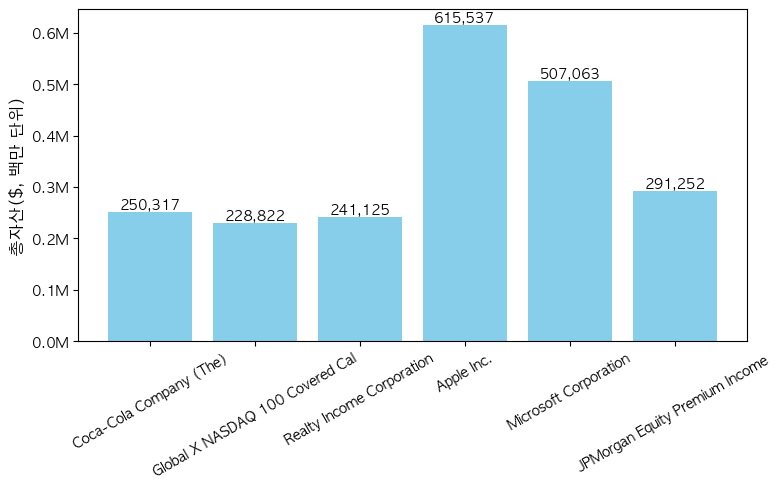

이 그래프는 동일한 초기 투자금(100,000$)을 10년간 투자했을 때, 각 종목별로 예상 총자산이 어떻게 되는지를 보여줍니다.


## 10년 후 종목별 총자산 요약

,종목,투자금($),10년 평가액($),10년 누적 배당($),총자산($)
0,Coca-Cola Company (The),"100,000","224,091","26,226","250,317"
1,Global X NASDAQ 100 Covered Cal,"100,000","135,762","93,060","228,822"
2,Realty Income Corporation,"100,000","203,055","38,070","241,125"
3,Apple Inc.,"100,000","611,307","4,230","615,537"
4,Microsoft Corporation,"100,000","500,295","6,768","507,063"
5,JPMorgan Equity Premium Income,"100,000","223,572","67,680","291,252"


이 표는 그래프에서 시각화한 각 종목별 10년 후 평가액 및 누적 배당, 총자산 값을 숫자로 정리한 것입니다.


## 매달 $10000 배당 받으려면 필요한 투자금

,종목,배당 수익률(%),필요 투자금($)
0,Coca-Cola Company (The),3.1,"4,575,612"
1,Global X NASDAQ 100 Covered Cal,11.0,"1,289,491"
2,Realty Income Corporation,4.5,"3,152,088"
3,Apple Inc.,0.5,"28,368,794"
4,Microsoft Corporation,0.8,"17,730,496"
5,JPMorgan Equity Premium Income,8.0,"1,773,050"


이 표는 매달 10,000$를 배당으로 받기 위해 각 종목에 얼마나 투자해야 하는지를 계산한 결과입니다.


## 주가 분포 요약 (평균·분산·표준편차·상승비율·PER)

,종목,현재 주가($),평균 미래주가($),분산($),표준편차($),상승비율(%),PER
0,Coca-Cola Company (The),71.019997,159.15,"9,589.35",97.93,124.1,28.5
1,Global X NASDAQ 100 Covered Cal,16.590000,22.52,127.34,11.28,35.8,16.6
2,Realty Income Corporation,57.639999,117.04,"8,349.32",91.37,103.1,52.4
3,Apple Inc.,196.449997,"1,200.91","1,984,054.80","1,408.56",511.3,30.6
4,Microsoft Corporation,474.959991,"2,376.20","6,411,651.95","2,532.12",400.3,36.8
5,JPMorgan Equity Premium Income,56.040001,125.29,"2,428.12",49.28,123.6,56.0


이 표는 10년 후 주가를 10,000번 시뮬레이션한 뒤, 평균 가격, 분산, 표준편차, 상승률, PER을 정리한 것입니다.


## 주가 분포 히스토그램

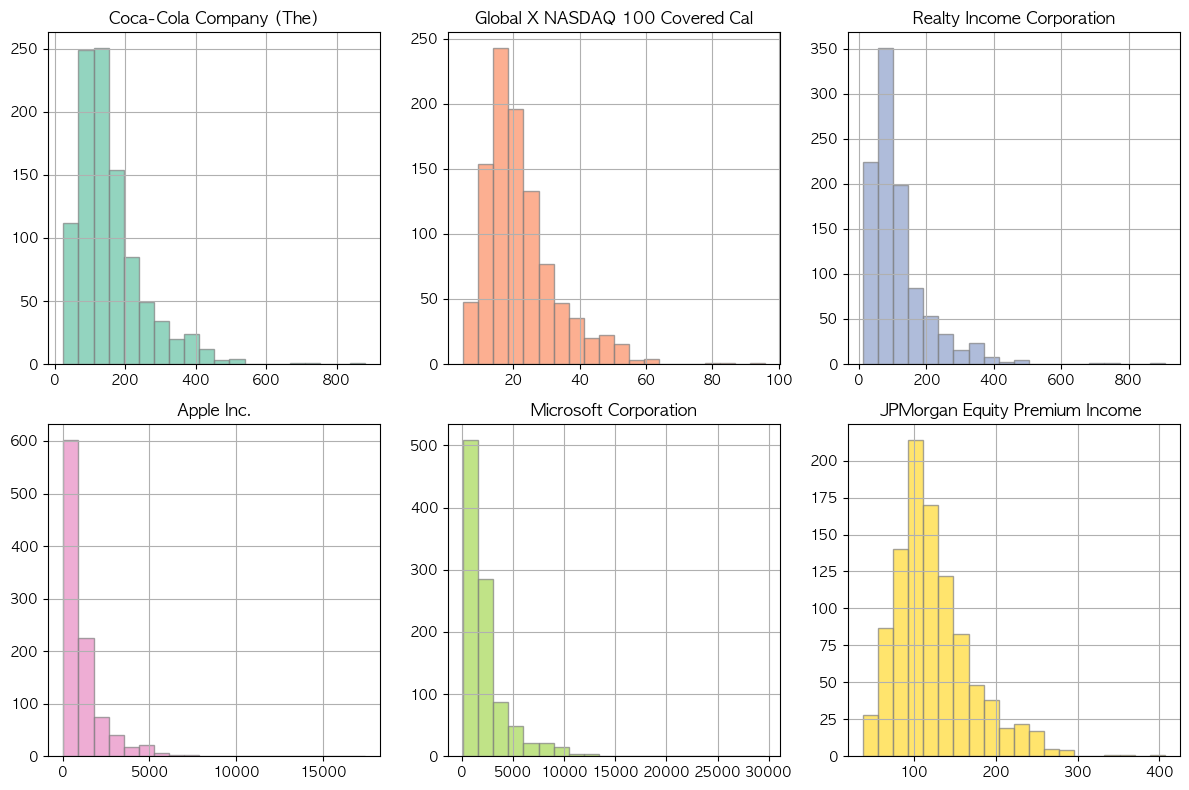

이 히스토그램은 10년 후 주가 분포의 형태를 보여줍니다. 봉우리 위치나 퍼짐 정도로 가격 변동성을 가늠할 수 있습니다.


In [243]:
# ====== 메인 실행 ======
if __name__ == '__main__':
    summary, inv_req, stats, stocks = [], [], [], []

    # 각 티커에 대해 데이터를 불러오고, 클래스 인스턴스 생성 후
    # 요약, 목표 투자금, 통계용 데이터를 리스트에 모읍니다.
    for i, tk in enumerate(TICKERS):
        name, price, dy, eps = get_real_stock_data(tk)
        mu, sigma, div = PARAMS[tk]
        stk = DividendStock(name, mu, sigma, price, div, eps)
        sd = SEED_BASE # 동일한 시드(4637)
        stocks.append((stk, sd))
        summary.append(stk.to_summary_row(FIXED_INVEST, YEARS, sd))
        inv_req.append(stk.to_inv_req_row(MONTHLY_TARGET))
        stats.append(stk.to_stats_row(YEARS, sd))

    # DataFrame 형태로 변환해 보기 좋게 정리합니다.
    df_sum   = pd.DataFrame(summary)
    df_inv   = pd.DataFrame(inv_req)
    df_stats = pd.DataFrame(stats)

    # 모든 멤버변수·함수 호출 확인 [조건5]
    # 1) 총 자산 비교 그래프
    plot_total_assets(df_sum)
    print("이 그래프는 동일한 초기 투자금(100,000$)을 10년간 투자했을 때, 각 종목별로 예상 총자산이 어떻게 되는지를 보여줍니다.")


    # 2) 10년 후 종목별 총자산 요약
    display(Markdown("## 10년 후 종목별 총자산 요약"))
    display(df_sum)   # 요약표 
    print("이 표는 그래프에서 시각화한 각 종목별 10년 후 평가액 및 누적 배당, 총자산 값을 숫자로 정리한 것입니다.")

    #3) 매달 월 배당 목표 투자금
    display(Markdown(f"## 매달 ${MONTHLY_TARGET} 배당 받으려면 필요한 투자금"))
    display(df_inv)   # 투자금 계산표 출력
    print("이 표는 매달 10,000$를 배당으로 받기 위해 각 종목에 얼마나 투자해야 하는지를 계산한 결과입니다.")

    # 4) 주가 분포 요약
    display(Markdown("## 주가 분포 요약 (평균·분산·표준편차·상승비율·PER)"))
    display(df_stats) # 분포 통계표 출력
    print("이 표는 10년 후 주가를 10,000번 시뮬레이션한 뒤, 평균 가격, 분산, 표준편차, 상승률, PER을 정리한 것입니다.")

    # 5) 주가 분포 히스토그램
    plot_histograms(stocks)
    print("이 히스토그램은 10년 후 주가 분포의 형태를 보여줍니다. 봉우리 위치나 퍼짐 정도로 가격 변동성을 가늠할 수 있습니다.")




## 과제 조건(1~5) 충족 여부


### [조건 1] : 필수 멤버변수 `S₀(price)`, `μ`, `σ` 선언 및 `yfinance` 로드
- `get_real_stock_data()` 함수 내에서 `price`, `div_yield`, `eps` 로드
- `DividendStock.__init__()`에서 `self.mu`, `self.sigma`, `self.price` 초기화

---

### [조건 2] : T년 후 주가 반환 메서드 구현 (`simulate`)
- `DividendStock.simulate(years, seed, n)`에서 **GBM 방식**으로 주가 샘플링

---

### [조건 3]: 표본평균 · 표본분산 계산 메서드 구현 (`sample_statistics`)
- `DividendStock.sample_statistics(years, seed, n)`에서 평균과 분산 계산 및 반환
- `to_summary_row`, `to_stats_row`에서 이 메서드를 호출하여 활용

---

### [조건 4] : 멤버변수 5개 이상, 멤버함수 5개 이상 구현
- **멤버변수**  
  - `mu`, `sigma`, `price`, `div_yield`, `eps`, `name` → 총 6개
- **멤버함수**  
  - `simulate`, `sample_statistics`, `dividend_income`, `required_investment`, `compute_per`  
  - `to_summary_row`, `to_inv_req_row`, `to_stats_row` → 총 8개
  
--- 

### [조건 5] : 정의된 멤버함수 및 멤버변수 모두 1회 이상 호출
- `simulate`: 직접 호출 + `sample_statistics()` 내부에서 사용됨
- `sample_statistics`: `to_summary_row`, `to_stats_row`에서 호출됨
- `dividend_income`: `to_summary_row`에서 호출됨
- `required_investment`: `to_inv_req_row`에서 호출됨
- `compute_per`: `to_stats_row`에서 호출됨
- `seed`: `main` 루프에서 `SEED_BASE + i`로 매 호출마다 다르게 설정됨
